In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd

In [3]:
train_path = '/kaggle/input/adobetraindata/behaviour_simulation_train.csv'
test_path = '/kaggle/input/inter-iit-mid-prep-adobe/problem_1_test_dataset/behaviour_simulation_test_company.xlsx'

In [4]:
test_dataset = pd.read_excel(test_path)

In [5]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                10000 non-null  int64 
 1   date              10000 non-null  object
 2   content           10000 non-null  object
 3   username          10000 non-null  object
 4   media             10000 non-null  object
 5   inferred company  10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


In [6]:
train_dataset = pd.read_csv(train_path)

In [7]:
train_dataset

,id,date,likes,content,username,media,inferred company
0,1,2020-12-12 00:47:00,1,"Spend your weekend morning with a Ham, Egg, an...",TimHortonsPH,[Photo(previewUrl='https://pbs.twimg.com/media...,tim hortons
1,2,2018-06-30 10:04:20,2750,Watch rapper <mention> freestyle for over an H...,IndyMusic,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
2,3,2020-09-29 19:47:28,57,Canadian Armenian community demands ban on mil...,CBCCanada,[Photo(previewUrl='https://pbs.twimg.com/media...,cbc
3,4,2020-10-01 11:40:09,152,"1st in Europe to be devastated by COVID-19, It...",MKWilliamsRome,[Photo(previewUrl='https://pbs.twimg.com/media...,williams
4,5,2018-10-19 14:30:46,41,Congratulations to Pauletha Butts of <mention>...,BGISD,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
...,...,...,...,...,...,...,...
299995,299996,2019-09-07 16:18:10,0,Barcelona Star Expected To Return Against Vale...,IndependentNGR,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
299996,299997,2018-02-23 11:24:36,46,Kjeld Nuis of #NED is golden again... This tim...,CBCOlympics,[Video(thumbnailUrl='https://pbs.twimg.com/med...,cbc
299997,299998,2020-11-11 20:18:15,261,Grateful 🙌🏾 to have <mention> officially join ...,TeamCoachBuzz,[Photo(previewUrl='https://pbs.twimg.com/media...,williams
299998,299999,2019-10-29 10:44:00,119,The US Air Force's mysterious space plane just...,Independent,[Video(thumbnailUrl='https://pbs.twimg.com/med...,independent


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
# Load data
train_data = train_dataset.copy()
test_data = test_dataset.copy()
# Bin the likes into categories
# Define the cap threshold
cap_value = 20000
# Apply the cap to the 'likes' column
train_data['likes_capped'] = train_data['likes'].apply(lambda x: min(x, cap_value))
# Check the distribution of the capped 'likes' column
print(train_data['likes_capped'].describe())
bins = [0, 100, 1000, 10000, 100000]
labels = ['0-100', '101-1k','1k-10k','10k+']
train_data['likes_binned'] = pd.cut(train_data['likes_capped'], bins=bins, labels=labels, include_lowest=True)
# Sample 10% of the data, stratified by binned likes
sample_fraction = 0.01  # Change this to 1.0 for 100%
train_data_sampled, _ = train_test_split(train_data, test_size=1-sample_fraction, random_state=42, stratify=train_data['likes_binned'])
train_data_sampled = train_data_sampled.reset_index(drop=1)
train_data_sampled = train_data.copy()

# Check distribution
print(train_data_sampled['likes_binned'].value_counts(normalize=True))


count    300000.000000
mean        643.547447
std        2128.732465
min           0.000000
25%           3.000000
50%          76.000000
75%         364.000000
max       20000.000000
Name: likes_capped, dtype: float64
likes_binned
0-100     0.548557
101-1k    0.327200
1k-10k    0.111780
10k+      0.012463
Name: proportion, dtype: float64


In [9]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 43.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [10]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
import networkx as nx
from node2vec import Node2Vec
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import emoji

# Ensure you've downloaded necessary NLTK data
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
# def preprocess_text(text):
#     # Convert to lowercase
#     text = text.lower()
#     # Remove URLs
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
#     # Remove user mentions
#     text = re.sub(r'@\w+', '', text)
#     # Remove non-letter characters
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     # Remove extra spaces
#     text = re.sub(r'\s+', ' ', text).strip()
#     # Remove stopwords
#     stop_words = set(stopwords.words('english'))
#     text = ' '.join([word for word in text.split() if word not in stop_words])
#     return text

# def get_roberta_embedding(text):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     return outputs.last_hidden_state.mean(dim=1).numpy().flatten()

# def get_datetime_features(date_str):
#     date = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
#     return np.array([
#         date.year, date.month, date.day, date.hour, date.minute,
#         date.weekday(), date.timetuple().tm_yday,
#         np.sin(2 * np.pi * date.hour / 24),  # Cyclical encoding for hour
#         np.cos(2 * np.pi * date.hour / 24),
#         np.sin(2 * np.pi * date.month / 12),  # Cyclical encoding for month
#         np.cos(2 * np.pi * date.month / 12)
#     ])

# def get_categorical_embedding(value, encoder):
#     return encoder.transform([[value]]).toarray().flatten()

# def create_graph_embedding(df):
#     G = nx.Graph()
#     for _, row in df.iterrows():
#         G.add_edge(row['username'], row['inferred company'])
#         for mention in re.findall(r'@(\w+)', row['content']):
#             G.add_edge(row['username'], mention)
    
#     node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
#     model = node2vec.fit(window=10, min_count=1, batch_words=4)
    
#     def get_node_embedding(node):
#         try:
#             return model.wv[node]
#         except KeyError:
#             return np.zeros(64)
    
#     df['user_graph_embedding'] = df['username'].apply(get_node_embedding)
#     df['company_graph_embedding'] = df['inferred company'].apply(get_node_embedding)
#     return df

# def extract_hashtags(text):
#     return ' '.join(re.findall(r'#(\w+)', text))

# def extract_emoji(text):
#     return ' '.join([c for c in text if c in emoji.UNICODE_EMOJI['en']])

# # Load the data
# df = pd.read_csv("tweets.csv")

# # Preprocess text
# df['processed_content'] = df['content'].apply(preprocess_text)
# df['hashtags'] = df['content'].apply(extract_hashtags)
# df['emojis'] = df['content'].apply(extract_emoji)

# # Combine all text data
# df['combined_text'] = df.apply(lambda row: f"{row['processed_content']} {row['username']} {row['inferred company']} {row['hashtags']} {row['emojis']}", axis=1)

# # Generate text embeddings
# df['combined_embedding'] = df['combined_text'].apply(get_roberta_embedding)

# # Generate datetime embeddings
# df['datetime_embedding'] = df['date'].apply(get_datetime_features)

# # Generate categorical embeddings
# company_encoder = OneHotEncoder(sparse=False)
# company_encoder.fit(df['inferred company'].values.reshape(-1, 1))
# df['company_embedding'] = df['inferred company'].apply(lambda x: get_categorical_embedding(x, company_encoder))

# # Generate graph embeddings
# df = create_graph_embedding(df)

# # Combine all embeddings
# df['rich_embedding'] = df.apply(lambda row: np.concatenate([
#     row['combined_embedding'],
#     row['datetime_embedding'],
#     row['company_embedding'],
#     row['user_graph_embedding'],
#     row['company_graph_embedding']
# ]), axis=1)

# print("Rich embeddings generated successfully!")
# print(f"Shape of rich embedding: {df['rich_embedding'].iloc[0].shape}")

# # Optional: Dimensionality reduction if needed
# # from sklearn.decomposition import PCA
# # pca = PCA(n_components=100)
# # df['reduced_embedding'] = list(pca.fit_transform(np.stack(df['rich_embedding'])))

# # Save the embeddings
# np.save('rich_tweet_embeddings.npy', np.stack(df['rich_embedding']))
# df[['id', 'content', 'username', 'inferred company']].to_csv('tweet_metadata.csv', index=False)

# print("Embeddings and metadata saved successfully!")

In [12]:
# tokenize_username('AAASouthJersey')

In [13]:
# set(df['username'])

In [14]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime
import networkx as nx
from node2vec import Node2Vec
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import emoji
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load specialized Twitter model
model_name = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

Using device: cuda


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [15]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Remove non-letter characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

def get_roberta_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

def get_datetime_features(date_str):
    date = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    return np.array([
        date.year, date.month, date.day, date.hour, date.minute,
        date.weekday(), date.timetuple().tm_yday,
        np.sin(2 * np.pi * date.hour / 24),  # Cyclical encoding for hour
        np.cos(2 * np.pi * date.hour / 24),
        np.sin(2 * np.pi * date.month / 12),  # Cyclical encoding for month
        np.cos(2 * np.pi * date.month / 12)
    ])

def get_categorical_embedding(value, encoder):
    return encoder.transform([[value]]).flatten()

def create_graph_embedding(df):
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_edge(row['username'], row['inferred company'])
        for mention in re.findall(r'@(\w+)', row['content']):
            G.add_edge(row['username'], mention)
    
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    
    def get_node_embedding(node):
        try:
            return model.wv[node]
        except KeyError:
            return np.zeros(64)
    
    df['user_graph_embedding'] = df['username'].apply(get_node_embedding)
    df['company_graph_embedding'] = df['inferred company'].apply(get_node_embedding)
    return df

def extract_hashtags(text):
    return ' '.join(re.findall(r'#(\w+)', text))

def extract_emoji(text):
    return ' '.join([c for c in text if emoji.is_emoji(c)])

In [16]:
# # Label encode the binned categories
# le = LabelEncoder()
# y = le.fit_transform(train_data_sampled['likes_binned'])

# # Define the groups based on the 'inferred_company'
# groups = train_data_sampled['inferred company']

# # Initialize GroupShuffleSplit with stratification
# gss = StratifiedGroupKFold(n_splits=5,shuffle=True, random_state=42)
# train_idx, val_idx = next(gss.split(train_data_sampled, train_data_sampled['likes_binned'], groups))
# # Perform the split
# # for train_idx, val_idx in gss.split(X_combined, y, groups):
# X_train, X_val = train_data_sampled.iloc[train_idx].reset_index(drop=True), train_data_sampled.iloc[val_idx].reset_index(drop=True)
# y_train, y_val = train_data_sampled['likes_capped'].iloc[train_idx].reset_index(drop=True), train_data_sampled['likes_capped'].iloc[val_idx].reset_index(drop=True)

# # Ensure stratification within the group-based split
# # print(f"Training set class distribution: {np.bincount(y_train)}")
# # print(f"Validation set class distribution: {np.bincount(y_val)}")

In [17]:
# Load the data
df = train_data_sampled.copy()

# Preprocess text and combine data
print("Preprocessing train text...")
df['processed_content'] = df['content'].apply(preprocess_text)
df['hashtags'] = df['content'].apply(extract_hashtags)
df['emojis'] = df['content'].apply(extract_emoji)
df['combined_text'] = df.apply(lambda row: f"{row['processed_content']} {row['username']} {row['hashtags']} {row['emojis']}", axis=1)

Preprocessing train text...


In [18]:
# Generate embeddings with progress bar
print("Generating embeddings...")
embeddings = []
for text in tqdm(df['combined_text'], desc="Generating text embeddings"):
    embeddings.append(get_roberta_embedding(text))
df['combined_embedding'] = embeddings

Generating embeddings...


Generating text embeddings: 100%|██████████| 300000/300000 [43:00<00:00, 116.25it/s]


In [19]:
# Generate other embeddings
print("Generating other embeddings...")
df['datetime_embedding'] = df['date'].apply(get_datetime_features)

# company_encoder = OneHotEncoder(sparse=False)
# company_encoder.fit(df['inferred company'].values.reshape(-1, 1))
# df['company_embedding'] = df['inferred company'].apply(lambda x: get_categorical_embedding(x, company_encoder))

Generating other embeddings...


In [20]:
import re
import numpy as np
import pandas as pd
from collections import Counter
from transformers import pipeline, AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
import torch
from tqdm import tqdm  # For progress tracking

# Load the training data
# df = pd.read_csv("train_tweets.csv")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check for GPU

# 1. Tokenize usernames and perform word frequency analysis
def tokenize_username(username):
    username = username.replace('_', ' ')
    username_parts = re.findall(r'[A-Z][a-z]*|[a-z]+|\d+', username)
    return [word.lower() for word in username_parts]

df['tokenized_username'] = df['username'].apply(tokenize_username)

# 5. Username Embedding Generation using Pre-trained Model
model_name = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)  # Move model to GPU

def get_username_embedding(username):
    tokenized = tokenizer(username, return_tensors="pt", truncation=True, padding=True).to(device)  # Move inputs to GPU
    with torch.no_grad():
        outputs = model(**tokenized)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()  # Move back to CPU

# Apply embedding generation with progress tracking
df['username_embedding'] = [get_username_embedding(' '.join(tokenize_username(username))) for username in tqdm(df['username'], desc="Embedding Generation")]

# 6. Dimensionality Reduction with PCA
pca = PCA(n_components=64)
df['reduced_username_embedding'] = list(pca.fit_transform(np.stack(df['username_embedding'])))

# 7. Feature List
print("Training features generated successfully!")
print("Feature columns for use in neural network:")
print(df.columns)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Embedding Generation: 100%|██████████| 300000/300000 [40:54<00:00, 122.23it/s]


Training features generated successfully!
Feature columns for use in neural network:
Index(['id', 'date', 'likes', 'content', 'username', 'media',
       'inferred company', 'likes_capped', 'likes_binned', 'processed_content',
       'hashtags', 'emojis', 'combined_text', 'combined_embedding',
       'datetime_embedding', 'tokenized_username', 'username_embedding',
       'reduced_username_embedding'],
      dtype='object')


In [21]:
# Combine all embeddings
print("Combining embeddings...")
df['rich_embedding'] = df.apply(lambda row: np.concatenate([
    row['combined_embedding'],
    row['datetime_embedding'],
    row['reduced_username_embedding']
    # row['company_embedding']
    # row['user_graph_embedding'],
    # row['company_graph_embedding']
]), axis=1)

print(f"Shape of rich embedding: {df['rich_embedding'].iloc[0].shape}")

Combining embeddings...
Shape of rich embedding: (843,)


In [22]:
pca.explained_variance_ratio_.sum()

0.8711718347298265

In [23]:
# # Load the data
# df = X_val

# # Preprocess text and combine data
# print("Preprocessing val text...")
# df['processed_content'] = df['content'].apply(preprocess_text)
# df['hashtags'] = df['content'].apply(extract_hashtags)
# df['emojis'] = df['content'].apply(extract_emoji)
# df['combined_text'] = df.apply(lambda row: f"{row['processed_content']} {row['username']} {row['inferred company']} {row['hashtags']} {row['emojis']}", axis=1)

In [24]:
# # Generate embeddings with progress bar
# print("Generating embeddings...")
# embeddings = []
# for text in tqdm(df['combined_text'], desc="Generating text embeddings"):
#     embeddings.append(get_roberta_embedding(text))
# df['combined_embedding'] = embeddings

In [25]:
# # Generate other embeddings
# print("Generating other embeddings...")
# df['datetime_embedding'] = df['date'].apply(get_datetime_features)

# # company_encoder = OneHotEncoder(sparse=False)
# # company_encoder.fit(df['inferred company'].values.reshape(-1, 1))
# df['company_embedding'] = df['inferred company'].apply(lambda x: get_categorical_embedding(x, company_encoder))

In [26]:
# # Combine all embeddings
# print("Combining embeddings...")
# df['rich_embedding'] = df.apply(lambda row: np.concatenate([
#     row['combined_embedding'],
#     row['datetime_embedding'],
#     row['company_embedding']
#     # row['user_graph_embedding'],
#     # row['company_graph_embedding']
# ]), axis=1)

# print(f"Shape of rich embedding: {df['rich_embedding'].iloc[0].shape}")

In [27]:
# print("Creating graph embeddings...")
# df = create_graph_embedding(df)

In [28]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Prepare data for regression
X = np.stack(df['rich_embedding'])
y = df['likes_capped'].values

# Log transform the target variable to handle skewness
y = np.log1p(y)  # log1p is used to handle zero values

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [30]:
# Define a neural network for regression
class TweetLikesRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(TweetLikesRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x.squeeze()

# Create dataset and dataloader
class TweetDataset(Dataset):
    def __init__(self, embeddings, likes):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.likes = torch.tensor(likes, dtype=torch.float32)
    
    def __len__(self):
        return len(self.likes)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.likes[idx]

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 256
batch_size = 64
num_epochs = 100
learning_rate = 0.001

In [31]:
# Create model, optimizer, and loss function
model = TweetLikesRegressor(input_dim, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [32]:
# Create datasets and dataloaders
train_dataset = TweetDataset(X_train_scaled, y_train)
val_dataset = TweetDataset(X_val_scaled, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [33]:
# Training loop
print("Training regression model...")
best_val_mse = float('inf')
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_embeddings, batch_likes in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_embeddings, batch_likes = batch_embeddings.to(device), batch_likes.to(device)
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_likes)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for batch_embeddings, batch_likes in val_loader:
            batch_embeddings, batch_likes = batch_embeddings.to(device), batch_likes.to(device)
            outputs = model(batch_embeddings)
            val_preds.extend(outputs.cpu().numpy())
            val_true.extend(batch_likes.cpu().numpy())
    
    val_mse = mean_squared_error(val_true, val_preds)
    val_mae = mean_absolute_error(val_true, val_preds)
    val_r2 = r2_score(val_true, val_preds)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")
    print(f"Val MSE: {val_mse:.4f}, Val MAE: {val_mae:.4f}, Val R2: {val_r2:.4f}")
    
    # Save the best model
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        torch.save(model.state_dict(), 'best_tweet_likes_regressor.pth')
        print("New best model saved!")

print("Training completed!")

Training regression model...


Epoch 1/100: 100%|██████████| 3750/3750 [00:09<00:00, 415.72it/s]


Epoch 1/100, Loss: 1.8216
Val MSE: 1.2922, Val MAE: 0.8122, Val R2: 0.8092
New best model saved!


Epoch 2/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.88it/s]


Epoch 2/100, Loss: 1.3643
Val MSE: 1.0872, Val MAE: 0.7657, Val R2: 0.8395
New best model saved!


Epoch 3/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.88it/s]


Epoch 3/100, Loss: 1.2211
Val MSE: 0.9616, Val MAE: 0.7160, Val R2: 0.8580
New best model saved!


Epoch 4/100: 100%|██████████| 3750/3750 [00:08<00:00, 421.68it/s]


Epoch 4/100, Loss: 1.1250
Val MSE: 0.9018, Val MAE: 0.6774, Val R2: 0.8669
New best model saved!


Epoch 5/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.90it/s]


Epoch 5/100, Loss: 1.0615
Val MSE: 0.8683, Val MAE: 0.6770, Val R2: 0.8718
New best model saved!


Epoch 6/100: 100%|██████████| 3750/3750 [00:09<00:00, 413.11it/s]


Epoch 6/100, Loss: 1.0150
Val MSE: 0.8238, Val MAE: 0.6447, Val R2: 0.8784
New best model saved!


Epoch 7/100: 100%|██████████| 3750/3750 [00:09<00:00, 401.26it/s]


Epoch 7/100, Loss: 0.9778
Val MSE: 0.8893, Val MAE: 0.6722, Val R2: 0.8687


Epoch 8/100: 100%|██████████| 3750/3750 [00:08<00:00, 429.55it/s]


Epoch 8/100, Loss: 0.9474
Val MSE: 0.8135, Val MAE: 0.6361, Val R2: 0.8799
New best model saved!


Epoch 9/100: 100%|██████████| 3750/3750 [00:08<00:00, 429.57it/s]


Epoch 9/100, Loss: 0.9246
Val MSE: 0.7891, Val MAE: 0.6250, Val R2: 0.8835
New best model saved!


Epoch 10/100: 100%|██████████| 3750/3750 [00:08<00:00, 428.85it/s]


Epoch 10/100, Loss: 0.9014
Val MSE: 0.7726, Val MAE: 0.6332, Val R2: 0.8859
New best model saved!


Epoch 11/100: 100%|██████████| 3750/3750 [00:09<00:00, 414.58it/s]


Epoch 11/100, Loss: 0.8838
Val MSE: 0.8105, Val MAE: 0.6384, Val R2: 0.8803


Epoch 12/100: 100%|██████████| 3750/3750 [00:08<00:00, 430.35it/s]


Epoch 12/100, Loss: 0.8630
Val MSE: 0.7798, Val MAE: 0.6209, Val R2: 0.8849


Epoch 13/100: 100%|██████████| 3750/3750 [00:08<00:00, 430.56it/s]


Epoch 13/100, Loss: 0.8516
Val MSE: 0.8081, Val MAE: 0.6642, Val R2: 0.8807


Epoch 14/100: 100%|██████████| 3750/3750 [00:08<00:00, 425.09it/s]


Epoch 14/100, Loss: 0.8369
Val MSE: 0.7747, Val MAE: 0.6534, Val R2: 0.8856


Epoch 15/100: 100%|██████████| 3750/3750 [00:08<00:00, 430.43it/s]


Epoch 15/100, Loss: 0.8279
Val MSE: 0.7802, Val MAE: 0.6537, Val R2: 0.8848


Epoch 16/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.76it/s]


Epoch 16/100, Loss: 0.8134
Val MSE: 0.7898, Val MAE: 0.6274, Val R2: 0.8834


Epoch 17/100: 100%|██████████| 3750/3750 [00:08<00:00, 428.60it/s]


Epoch 17/100, Loss: 0.8051
Val MSE: 0.7412, Val MAE: 0.6247, Val R2: 0.8906
New best model saved!


Epoch 18/100: 100%|██████████| 3750/3750 [00:08<00:00, 425.99it/s]


Epoch 18/100, Loss: 0.7935
Val MSE: 0.7545, Val MAE: 0.6293, Val R2: 0.8886


Epoch 19/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.63it/s]


Epoch 19/100, Loss: 0.7848
Val MSE: 0.7644, Val MAE: 0.6334, Val R2: 0.8871


Epoch 20/100: 100%|██████████| 3750/3750 [00:08<00:00, 424.07it/s]


Epoch 20/100, Loss: 0.7771
Val MSE: 0.7754, Val MAE: 0.6276, Val R2: 0.8855


Epoch 21/100: 100%|██████████| 3750/3750 [00:08<00:00, 421.82it/s]


Epoch 21/100, Loss: 0.7701
Val MSE: 0.7462, Val MAE: 0.6097, Val R2: 0.8898


Epoch 22/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.90it/s]


Epoch 22/100, Loss: 0.7610
Val MSE: 0.7439, Val MAE: 0.6167, Val R2: 0.8902


Epoch 23/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.53it/s]


Epoch 23/100, Loss: 0.7557
Val MSE: 0.7332, Val MAE: 0.6169, Val R2: 0.8917
New best model saved!


Epoch 24/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.46it/s]


Epoch 24/100, Loss: 0.7507
Val MSE: 0.7620, Val MAE: 0.6071, Val R2: 0.8875


Epoch 25/100: 100%|██████████| 3750/3750 [00:08<00:00, 427.47it/s]


Epoch 25/100, Loss: 0.7451
Val MSE: 0.7222, Val MAE: 0.6134, Val R2: 0.8934
New best model saved!


Epoch 26/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.59it/s]


Epoch 26/100, Loss: 0.7354
Val MSE: 0.7375, Val MAE: 0.6043, Val R2: 0.8911


Epoch 27/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.80it/s]


Epoch 27/100, Loss: 0.7335
Val MSE: 0.7454, Val MAE: 0.6343, Val R2: 0.8899


Epoch 28/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.29it/s]


Epoch 28/100, Loss: 0.7249
Val MSE: 0.7331, Val MAE: 0.6147, Val R2: 0.8918


Epoch 29/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.67it/s]


Epoch 29/100, Loss: 0.7222
Val MSE: 0.7428, Val MAE: 0.6010, Val R2: 0.8903


Epoch 30/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.08it/s]


Epoch 30/100, Loss: 0.7181
Val MSE: 0.7468, Val MAE: 0.6320, Val R2: 0.8897


Epoch 31/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.52it/s]


Epoch 31/100, Loss: 0.7105
Val MSE: 0.7273, Val MAE: 0.6154, Val R2: 0.8926


Epoch 32/100: 100%|██████████| 3750/3750 [00:08<00:00, 427.46it/s]


Epoch 32/100, Loss: 0.7077
Val MSE: 0.8053, Val MAE: 0.6724, Val R2: 0.8811


Epoch 33/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.17it/s]


Epoch 33/100, Loss: 0.7016
Val MSE: 0.7458, Val MAE: 0.6369, Val R2: 0.8899


Epoch 34/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.77it/s]


Epoch 34/100, Loss: 0.6967
Val MSE: 0.7205, Val MAE: 0.6110, Val R2: 0.8936
New best model saved!


Epoch 35/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.09it/s]


Epoch 35/100, Loss: 0.6925
Val MSE: 0.7252, Val MAE: 0.6071, Val R2: 0.8929


Epoch 36/100: 100%|██████████| 3750/3750 [00:08<00:00, 429.67it/s]


Epoch 36/100, Loss: 0.6891
Val MSE: 0.7265, Val MAE: 0.6180, Val R2: 0.8927


Epoch 37/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.28it/s]


Epoch 37/100, Loss: 0.6821
Val MSE: 0.8655, Val MAE: 0.6596, Val R2: 0.8722


Epoch 38/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.08it/s]


Epoch 38/100, Loss: 0.6785
Val MSE: 0.7319, Val MAE: 0.5942, Val R2: 0.8919


Epoch 39/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.73it/s]


Epoch 39/100, Loss: 0.6747
Val MSE: 0.7432, Val MAE: 0.6156, Val R2: 0.8903


Epoch 40/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.75it/s]


Epoch 40/100, Loss: 0.6721
Val MSE: 0.7271, Val MAE: 0.5995, Val R2: 0.8927


Epoch 41/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.87it/s]


Epoch 41/100, Loss: 0.6705
Val MSE: 0.7530, Val MAE: 0.6168, Val R2: 0.8888


Epoch 42/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.32it/s]


Epoch 42/100, Loss: 0.6690
Val MSE: 0.7129, Val MAE: 0.5958, Val R2: 0.8947
New best model saved!


Epoch 43/100: 100%|██████████| 3750/3750 [00:09<00:00, 408.66it/s]


Epoch 43/100, Loss: 0.6612
Val MSE: 0.7168, Val MAE: 0.5914, Val R2: 0.8942


Epoch 44/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.44it/s]


Epoch 44/100, Loss: 0.6581
Val MSE: 0.7239, Val MAE: 0.6162, Val R2: 0.8931


Epoch 45/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.19it/s]


Epoch 45/100, Loss: 0.6529
Val MSE: 0.7291, Val MAE: 0.6235, Val R2: 0.8924


Epoch 46/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.96it/s]


Epoch 46/100, Loss: 0.6522
Val MSE: 0.7159, Val MAE: 0.5931, Val R2: 0.8943


Epoch 47/100: 100%|██████████| 3750/3750 [00:08<00:00, 425.14it/s]


Epoch 47/100, Loss: 0.6480
Val MSE: 0.7197, Val MAE: 0.6106, Val R2: 0.8937


Epoch 48/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.56it/s]


Epoch 48/100, Loss: 0.6470
Val MSE: 0.7143, Val MAE: 0.5982, Val R2: 0.8945


Epoch 49/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.12it/s]


Epoch 49/100, Loss: 0.6427
Val MSE: 0.7295, Val MAE: 0.6004, Val R2: 0.8923


Epoch 50/100: 100%|██████████| 3750/3750 [00:08<00:00, 428.42it/s]


Epoch 50/100, Loss: 0.6437
Val MSE: 0.7274, Val MAE: 0.5976, Val R2: 0.8926


Epoch 51/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.41it/s]


Epoch 51/100, Loss: 0.6381
Val MSE: 0.7152, Val MAE: 0.6075, Val R2: 0.8944


Epoch 52/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.22it/s]


Epoch 52/100, Loss: 0.6356
Val MSE: 0.7140, Val MAE: 0.6070, Val R2: 0.8946


Epoch 53/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.08it/s]


Epoch 53/100, Loss: 0.6362
Val MSE: 0.7186, Val MAE: 0.5931, Val R2: 0.8939


Epoch 54/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.23it/s]


Epoch 54/100, Loss: 0.6279
Val MSE: 0.7309, Val MAE: 0.6229, Val R2: 0.8921


Epoch 55/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.64it/s]


Epoch 55/100, Loss: 0.6254
Val MSE: 0.7086, Val MAE: 0.5860, Val R2: 0.8954
New best model saved!


Epoch 56/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.85it/s]


Epoch 56/100, Loss: 0.6245
Val MSE: 0.7304, Val MAE: 0.6187, Val R2: 0.8922


Epoch 57/100: 100%|██████████| 3750/3750 [00:08<00:00, 425.11it/s]


Epoch 57/100, Loss: 0.6156
Val MSE: 0.7520, Val MAE: 0.6131, Val R2: 0.8890


Epoch 58/100: 100%|██████████| 3750/3750 [00:08<00:00, 440.37it/s]


Epoch 58/100, Loss: 0.6228
Val MSE: 0.7473, Val MAE: 0.6357, Val R2: 0.8897


Epoch 59/100: 100%|██████████| 3750/3750 [00:08<00:00, 440.20it/s]


Epoch 59/100, Loss: 0.6178
Val MSE: 0.7216, Val MAE: 0.5956, Val R2: 0.8935


Epoch 60/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.48it/s]


Epoch 60/100, Loss: 0.6119
Val MSE: 0.7094, Val MAE: 0.5930, Val R2: 0.8953


Epoch 61/100: 100%|██████████| 3750/3750 [00:08<00:00, 428.16it/s]


Epoch 61/100, Loss: 0.6116
Val MSE: 0.7246, Val MAE: 0.6112, Val R2: 0.8930


Epoch 62/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.15it/s]


Epoch 62/100, Loss: 0.6099
Val MSE: 0.7145, Val MAE: 0.5965, Val R2: 0.8945


Epoch 63/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.62it/s]


Epoch 63/100, Loss: 0.6050
Val MSE: 0.7311, Val MAE: 0.5964, Val R2: 0.8920


Epoch 64/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.82it/s]


Epoch 64/100, Loss: 0.6000
Val MSE: 0.7191, Val MAE: 0.6024, Val R2: 0.8938


Epoch 65/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.82it/s]


Epoch 65/100, Loss: 0.6033
Val MSE: 0.7146, Val MAE: 0.5957, Val R2: 0.8945


Epoch 66/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.50it/s]


Epoch 66/100, Loss: 0.6003
Val MSE: 0.7154, Val MAE: 0.5924, Val R2: 0.8944


Epoch 67/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.53it/s]


Epoch 67/100, Loss: 0.5977
Val MSE: 0.7123, Val MAE: 0.5977, Val R2: 0.8948


Epoch 68/100: 100%|██████████| 3750/3750 [00:09<00:00, 408.32it/s]


Epoch 68/100, Loss: 0.5965
Val MSE: 0.7245, Val MAE: 0.6028, Val R2: 0.8930


Epoch 69/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.95it/s]


Epoch 69/100, Loss: 0.5908
Val MSE: 0.7124, Val MAE: 0.5975, Val R2: 0.8948


Epoch 70/100: 100%|██████████| 3750/3750 [00:08<00:00, 428.23it/s]


Epoch 70/100, Loss: 0.5904
Val MSE: 0.7409, Val MAE: 0.6145, Val R2: 0.8906


Epoch 71/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.17it/s]


Epoch 71/100, Loss: 0.5893
Val MSE: 0.7167, Val MAE: 0.6019, Val R2: 0.8942


Epoch 72/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.42it/s]


Epoch 72/100, Loss: 0.5876
Val MSE: 0.7681, Val MAE: 0.6084, Val R2: 0.8866


Epoch 73/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.50it/s]


Epoch 73/100, Loss: 0.5837
Val MSE: 0.7135, Val MAE: 0.6006, Val R2: 0.8947


Epoch 74/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.75it/s]


Epoch 74/100, Loss: 0.5816
Val MSE: 0.7391, Val MAE: 0.6089, Val R2: 0.8909


Epoch 75/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.81it/s]


Epoch 75/100, Loss: 0.5815
Val MSE: 0.7208, Val MAE: 0.6055, Val R2: 0.8936


Epoch 76/100: 100%|██████████| 3750/3750 [00:08<00:00, 429.62it/s]


Epoch 76/100, Loss: 0.5795
Val MSE: 0.7222, Val MAE: 0.6062, Val R2: 0.8934


Epoch 77/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.24it/s]


Epoch 77/100, Loss: 0.5784
Val MSE: 0.7255, Val MAE: 0.6052, Val R2: 0.8929


Epoch 78/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.74it/s]


Epoch 78/100, Loss: 0.5764
Val MSE: 0.7364, Val MAE: 0.5989, Val R2: 0.8913


Epoch 79/100: 100%|██████████| 3750/3750 [00:08<00:00, 425.13it/s]


Epoch 79/100, Loss: 0.5751
Val MSE: 0.7258, Val MAE: 0.6111, Val R2: 0.8928


Epoch 80/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.75it/s]


Epoch 80/100, Loss: 0.5725
Val MSE: 0.7360, Val MAE: 0.5957, Val R2: 0.8913


Epoch 81/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.27it/s]


Epoch 81/100, Loss: 0.5703
Val MSE: 0.7409, Val MAE: 0.6086, Val R2: 0.8906


Epoch 82/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.60it/s]


Epoch 82/100, Loss: 0.5734
Val MSE: 0.7226, Val MAE: 0.5926, Val R2: 0.8933


Epoch 83/100: 100%|██████████| 3750/3750 [00:08<00:00, 429.55it/s]


Epoch 83/100, Loss: 0.5649
Val MSE: 0.7328, Val MAE: 0.6071, Val R2: 0.8918


Epoch 84/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.91it/s]


Epoch 84/100, Loss: 0.5670
Val MSE: 0.7167, Val MAE: 0.5927, Val R2: 0.8942


Epoch 85/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.50it/s]


Epoch 85/100, Loss: 0.5656
Val MSE: 0.7320, Val MAE: 0.6092, Val R2: 0.8919


Epoch 86/100: 100%|██████████| 3750/3750 [00:08<00:00, 427.64it/s]


Epoch 86/100, Loss: 0.5619
Val MSE: 0.7348, Val MAE: 0.6049, Val R2: 0.8915


Epoch 87/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.73it/s]


Epoch 87/100, Loss: 0.5602
Val MSE: 0.7283, Val MAE: 0.5926, Val R2: 0.8925


Epoch 88/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.91it/s]


Epoch 88/100, Loss: 0.5635
Val MSE: 0.7302, Val MAE: 0.6001, Val R2: 0.8922


Epoch 89/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.92it/s]


Epoch 89/100, Loss: 0.5599
Val MSE: 0.7551, Val MAE: 0.6165, Val R2: 0.8885


Epoch 90/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.17it/s]


Epoch 90/100, Loss: 0.5576
Val MSE: 0.7192, Val MAE: 0.6009, Val R2: 0.8938


Epoch 91/100: 100%|██████████| 3750/3750 [00:08<00:00, 443.05it/s]


Epoch 91/100, Loss: 0.5558
Val MSE: 0.7559, Val MAE: 0.6226, Val R2: 0.8884


Epoch 92/100: 100%|██████████| 3750/3750 [00:08<00:00, 441.58it/s]


Epoch 92/100, Loss: 0.5580
Val MSE: 0.7256, Val MAE: 0.6014, Val R2: 0.8929


Epoch 93/100: 100%|██████████| 3750/3750 [00:08<00:00, 428.27it/s]


Epoch 93/100, Loss: 0.5514
Val MSE: 0.7157, Val MAE: 0.5972, Val R2: 0.8943


Epoch 94/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.08it/s]


Epoch 94/100, Loss: 0.5513
Val MSE: 0.7430, Val MAE: 0.6116, Val R2: 0.8903


Epoch 95/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.74it/s]


Epoch 95/100, Loss: 0.5528
Val MSE: 0.7123, Val MAE: 0.5999, Val R2: 0.8948


Epoch 96/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.17it/s]


Epoch 96/100, Loss: 0.5494
Val MSE: 0.7309, Val MAE: 0.6156, Val R2: 0.8921


Epoch 97/100: 100%|██████████| 3750/3750 [00:08<00:00, 428.78it/s]


Epoch 97/100, Loss: 0.5448
Val MSE: 0.7246, Val MAE: 0.6044, Val R2: 0.8930


Epoch 98/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.66it/s]


Epoch 98/100, Loss: 0.5488
Val MSE: 0.7455, Val MAE: 0.6022, Val R2: 0.8899


Epoch 99/100: 100%|██████████| 3750/3750 [00:08<00:00, 430.52it/s]


Epoch 99/100, Loss: 0.5446
Val MSE: 0.7626, Val MAE: 0.6396, Val R2: 0.8874


Epoch 100/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.46it/s]


Epoch 100/100, Loss: 0.5441
Val MSE: 0.7395, Val MAE: 0.6241, Val R2: 0.8908
Training completed!


In [34]:
# Function to get predictions for new data
def predict_likes(new_data):
    model.eval()
    with torch.no_grad():
        new_data_scaled = scaler.transform(new_data)
        embeddings = torch.tensor(new_data_scaled, dtype=torch.float32).to(device)
        outputs = model(embeddings)
        # Convert log predictions back to original scale
        return np.expm1(outputs.cpu().numpy())

# Example usage:
# new_likes_predictions = predict_likes(new_embeddings)
model.load_state_dict(torch.load('best_tweet_likes_regressor.pth'))
# Evaluate on test set
model.eval()
test_preds = []
test_true = y_val  # Using validation set as test set for this example
with torch.no_grad():
    for batch_embeddings, batch_likes in val_loader:
        batch_embeddings = batch_embeddings.to(device)
        outputs = model(batch_embeddings)
        test_preds.extend(outputs.cpu().numpy())

# Convert predictions back to original scale
test_preds = np.expm1(test_preds)
test_true = np.expm1(test_true)

# Calculate metrics on original scale
test_mse = mean_squared_error(test_true, test_preds)
test_mae = mean_absolute_error(test_true, test_preds)
test_r2 = r2_score(test_true, test_preds)

print("\nTest Set Evaluation (Original Scale):")
print(f"MSE: {test_mse:.2f}")
print(f"MAE: {test_mae:.2f}")
print(f"R2: {test_r2:.4f}")

# Calculate custom metrics for skewed data
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test_true, test_preds)
mdape = median_absolute_percentage_error(test_true, test_preds)

print(f"MAPE: {mape:.2f}%")
print(f"MdAPE: {mdape:.2f}%")

/tmp/ipykernel_23/1035189463.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_tweet_likes_regressor.pth'))



Test Set Evaluation (Original Scale):
MSE: 2706654.38
MAE: 411.86
R2: 0.3899
MAPE: inf%
MdAPE: 57.96%


/tmp/ipykernel_23/1035189463.py:40: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/tmp/ipykernel_23/1035189463.py:43: RuntimeWarning: divide by zero encountered in divide
  return np.median(np.abs((y_true - y_pred) / y_true)) * 100


In [35]:
temp_df = pd.DataFrame(test_preds)
temp_df.describe()

,0
count,60000.000000
mean,382.260773
std,1150.331299
min,-0.425246
25%,2.935600
50%,90.677559
75%,266.680550
max,42697.808594


In [36]:
temp_df = pd.DataFrame(test_true)
temp_df.describe()

,0
count,60000.000000
mean,641.619100
std,2106.301879
min,0.000000
25%,3.000000
50%,77.000000
75%,364.000000
max,20000.000000


In [37]:
# Calculate Pearson correlation coefficient
correlation = np.corrcoef(test_preds, test_true)[0,1]

print(f"Pearson correlation: {correlation}")

Pearson correlation: 0.6439143450701342


In [38]:
import matplotlib.pyplot as plt

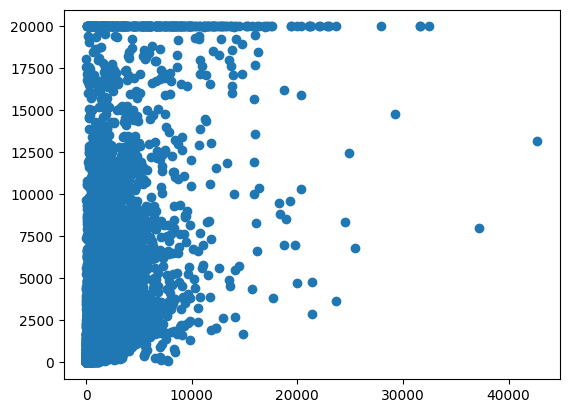

In [39]:
plt.scatter(test_preds,test_true)

In [40]:
# Prepare data for classification
X = np.stack(df['rich_embedding'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['likes_binned'])  # Assuming 'y' column exists with class labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Define a simple neural network for classification
class TweetClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(TweetClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create dataset and dataloader
class TweetDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 256
num_classes = len(np.unique(y))
batch_size = 64
num_epochs = 100
learning_rate = 0.001

In [42]:
# Create model, optimizer, and loss function
model = TweetClassifier(input_dim, hidden_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [43]:
# Create datasets and dataloaders
train_dataset = TweetDataset(X_train, y_train)
val_dataset = TweetDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [44]:
# Training loop
print("Training classification model...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_embeddings, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for batch_embeddings, batch_labels in val_loader:
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
            outputs = model(batch_embeddings)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(batch_labels.cpu().numpy())
    
    val_accuracy = accuracy_score(val_true, val_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(val_true, val_preds, average='weighted')
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

print("Training completed!")

# Save the model
torch.save(model.state_dict(), 'tweet_classifier.pth')
print("Model saved successfully!")

# Function to get predictions for new data
def predict(new_data):
    model.eval()
    with torch.no_grad():
        embeddings = torch.tensor(new_data, dtype=torch.float32).to(device)
        outputs = model(embeddings)
        _, preds = torch.max(outputs, 1)
    return label_encoder.inverse_transform(preds.cpu().numpy())

# Example usage:
# new_predictions = predict(new_embeddings)

Training classification model...


Epoch 1/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.33it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100, Loss: 0.9465, Val Accuracy: 0.6825
Precision: 0.6362, Recall: 0.6825, F1-score: 0.6482


Epoch 2/100: 100%|██████████| 3750/3750 [00:07<00:00, 486.11it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/100, Loss: 0.8006, Val Accuracy: 0.6919
Precision: 0.6417, Recall: 0.6919, F1-score: 0.6565


Epoch 3/100: 100%|██████████| 3750/3750 [00:07<00:00, 486.60it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/100, Loss: 0.7854, Val Accuracy: 0.6995
Precision: 0.6348, Recall: 0.6995, F1-score: 0.6611


Epoch 4/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.38it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/100, Loss: 0.7964, Val Accuracy: 0.6998
Precision: 0.6292, Recall: 0.6998, F1-score: 0.6599


Epoch 5/100: 100%|██████████| 3750/3750 [00:07<00:00, 477.33it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/100, Loss: 0.8005, Val Accuracy: 0.7019
Precision: 0.6254, Recall: 0.7019, F1-score: 0.6601


Epoch 6/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.72it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/100, Loss: 0.7979, Val Accuracy: 0.6991
Precision: 0.6412, Recall: 0.6991, F1-score: 0.6620


Epoch 7/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.12it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/100, Loss: 0.7979, Val Accuracy: 0.6830
Precision: 0.6715, Recall: 0.6830, F1-score: 0.6513


Epoch 8/100: 100%|██████████| 3750/3750 [00:08<00:00, 458.71it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/100, Loss: 0.7933, Val Accuracy: 0.6997
Precision: 0.6566, Recall: 0.6997, F1-score: 0.6648


Epoch 9/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.42it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/100, Loss: 0.7935, Val Accuracy: 0.6972
Precision: 0.6447, Recall: 0.6972, F1-score: 0.6611


Epoch 10/100: 100%|██████████| 3750/3750 [00:07<00:00, 488.47it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/100, Loss: 0.7925, Val Accuracy: 0.7075
Precision: 0.6402, Recall: 0.7075, F1-score: 0.6681


Epoch 11/100: 100%|██████████| 3750/3750 [00:07<00:00, 488.77it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/100, Loss: 0.7905, Val Accuracy: 0.7071
Precision: 0.6354, Recall: 0.7071, F1-score: 0.6666


Epoch 12/100: 100%|██████████| 3750/3750 [00:07<00:00, 473.21it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/100, Loss: 0.7894, Val Accuracy: 0.7016
Precision: 0.6199, Recall: 0.7016, F1-score: 0.6578


Epoch 13/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.04it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/100, Loss: 0.7876, Val Accuracy: 0.6969
Precision: 0.6074, Recall: 0.6969, F1-score: 0.6490


Epoch 14/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.44it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/100, Loss: 0.7869, Val Accuracy: 0.6925
Precision: 0.6692, Recall: 0.6925, F1-score: 0.6597


Epoch 15/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.49it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/100, Loss: 0.7870, Val Accuracy: 0.7067
Precision: 0.6544, Recall: 0.7067, F1-score: 0.6702


Epoch 16/100: 100%|██████████| 3750/3750 [00:07<00:00, 469.72it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/100, Loss: 0.7860, Val Accuracy: 0.6953
Precision: 0.6719, Recall: 0.6953, F1-score: 0.6622


Epoch 17/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.69it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/100, Loss: 0.7865, Val Accuracy: 0.7122
Precision: 0.6536, Recall: 0.7122, F1-score: 0.6744


Epoch 18/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.96it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/100, Loss: 0.7853, Val Accuracy: 0.7068
Precision: 0.6449, Recall: 0.7068, F1-score: 0.6687


Epoch 19/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.25it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/100, Loss: 0.7857, Val Accuracy: 0.7131
Precision: 0.6473, Recall: 0.7131, F1-score: 0.6738


Epoch 20/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.26it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/100, Loss: 0.7843, Val Accuracy: 0.7048
Precision: 0.6614, Recall: 0.7048, F1-score: 0.6694


Epoch 21/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.46it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/100, Loss: 0.7834, Val Accuracy: 0.7057
Precision: 0.6674, Recall: 0.7057, F1-score: 0.6709


Epoch 22/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.39it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/100, Loss: 0.7828, Val Accuracy: 0.7110
Precision: 0.6322, Recall: 0.7110, F1-score: 0.6681


Epoch 23/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.17it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/100, Loss: 0.7837, Val Accuracy: 0.7148
Precision: 0.6480, Recall: 0.7148, F1-score: 0.6753


Epoch 24/100: 100%|██████████| 3750/3750 [00:07<00:00, 469.03it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/100, Loss: 0.7830, Val Accuracy: 0.7096
Precision: 0.6539, Recall: 0.7096, F1-score: 0.6724


Epoch 25/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.75it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/100, Loss: 0.7815, Val Accuracy: 0.7144
Precision: 0.6497, Recall: 0.7144, F1-score: 0.6753


Epoch 26/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.29it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/100, Loss: 0.7825, Val Accuracy: 0.7105
Precision: 0.6617, Recall: 0.7105, F1-score: 0.6742


Epoch 27/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.60it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/100, Loss: 0.7801, Val Accuracy: 0.7031
Precision: 0.6691, Recall: 0.7031, F1-score: 0.6689


Epoch 28/100: 100%|██████████| 3750/3750 [00:07<00:00, 476.29it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/100, Loss: 0.7797, Val Accuracy: 0.7130
Precision: 0.6471, Recall: 0.7130, F1-score: 0.6737


Epoch 29/100: 100%|██████████| 3750/3750 [00:07<00:00, 487.09it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/100, Loss: 0.7807, Val Accuracy: 0.7132
Precision: 0.6469, Recall: 0.7132, F1-score: 0.6739


Epoch 30/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.70it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/100, Loss: 0.7798, Val Accuracy: 0.7028
Precision: 0.6133, Recall: 0.7028, F1-score: 0.6549


Epoch 31/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.17it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/100, Loss: 0.7789, Val Accuracy: 0.7151
Precision: 0.6482, Recall: 0.7151, F1-score: 0.6755


Epoch 32/100: 100%|██████████| 3750/3750 [00:07<00:00, 475.93it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/100, Loss: 0.7793, Val Accuracy: 0.6982
Precision: 0.6066, Recall: 0.6982, F1-score: 0.6487


Epoch 33/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.55it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/100, Loss: 0.7801, Val Accuracy: 0.7146
Precision: 0.6380, Recall: 0.7146, F1-score: 0.6724


Epoch 34/100: 100%|██████████| 3750/3750 [00:07<00:00, 476.42it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/100, Loss: 0.7789, Val Accuracy: 0.7075
Precision: 0.6638, Recall: 0.7075, F1-score: 0.6720


Epoch 35/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.19it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35/100, Loss: 0.7800, Val Accuracy: 0.7117
Precision: 0.6565, Recall: 0.7117, F1-score: 0.6745


Epoch 36/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.75it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/100, Loss: 0.7780, Val Accuracy: 0.7175
Precision: 0.6545, Recall: 0.7175, F1-score: 0.6786


Epoch 37/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.99it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37/100, Loss: 0.7796, Val Accuracy: 0.7116
Precision: 0.6659, Recall: 0.7116, F1-score: 0.6756


Epoch 38/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.30it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/100, Loss: 0.7791, Val Accuracy: 0.7123
Precision: 0.6333, Recall: 0.7123, F1-score: 0.6694


Epoch 39/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.90it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39/100, Loss: 0.7787, Val Accuracy: 0.7133
Precision: 0.6413, Recall: 0.7133, F1-score: 0.6725


Epoch 40/100: 100%|██████████| 3750/3750 [00:07<00:00, 477.84it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/100, Loss: 0.7774, Val Accuracy: 0.7113
Precision: 0.6421, Recall: 0.7113, F1-score: 0.6712


Epoch 41/100: 100%|██████████| 3750/3750 [00:07<00:00, 471.27it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41/100, Loss: 0.7784, Val Accuracy: 0.7148
Precision: 0.6372, Recall: 0.7148, F1-score: 0.6723


Epoch 42/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.76it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42/100, Loss: 0.7769, Val Accuracy: 0.7157
Precision: 0.6492, Recall: 0.7157, F1-score: 0.6762


Epoch 43/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.68it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 43/100, Loss: 0.7773, Val Accuracy: 0.7164
Precision: 0.6436, Recall: 0.7164, F1-score: 0.6753


Epoch 44/100: 100%|██████████| 3750/3750 [00:08<00:00, 466.38it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44/100, Loss: 0.7783, Val Accuracy: 0.7067
Precision: 0.6203, Recall: 0.7067, F1-score: 0.6607


Epoch 45/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.71it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 45/100, Loss: 0.7776, Val Accuracy: 0.7174
Precision: 0.6548, Recall: 0.7174, F1-score: 0.6785


Epoch 46/100: 100%|██████████| 3750/3750 [00:07<00:00, 488.82it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 46/100, Loss: 0.7769, Val Accuracy: 0.7177
Precision: 0.6438, Recall: 0.7177, F1-score: 0.6762


Epoch 47/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.81it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 47/100, Loss: 0.7762, Val Accuracy: 0.7151
Precision: 0.6618, Recall: 0.7151, F1-score: 0.6780


Epoch 48/100: 100%|██████████| 3750/3750 [00:08<00:00, 451.98it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 48/100, Loss: 0.7766, Val Accuracy: 0.7187
Precision: 0.6562, Recall: 0.7187, F1-score: 0.6798


Epoch 49/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.91it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 49/100, Loss: 0.7766, Val Accuracy: 0.7180
Precision: 0.6502, Recall: 0.7180, F1-score: 0.6781


Epoch 50/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.96it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/100, Loss: 0.7758, Val Accuracy: 0.7135
Precision: 0.6682, Recall: 0.7135, F1-score: 0.6776


Epoch 51/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.45it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 51/100, Loss: 0.7760, Val Accuracy: 0.7125
Precision: 0.6709, Recall: 0.7125, F1-score: 0.6769


Epoch 52/100: 100%|██████████| 3750/3750 [00:08<00:00, 467.13it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 52/100, Loss: 0.7751, Val Accuracy: 0.7171
Precision: 0.6490, Recall: 0.7171, F1-score: 0.6772


Epoch 53/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.70it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 53/100, Loss: 0.7754, Val Accuracy: 0.7069
Precision: 0.6178, Recall: 0.7069, F1-score: 0.6593


Epoch 54/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.16it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 54/100, Loss: 0.7749, Val Accuracy: 0.7141
Precision: 0.6597, Recall: 0.7141, F1-score: 0.6769


Epoch 55/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.77it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 55/100, Loss: 0.7744, Val Accuracy: 0.7059
Precision: 0.6741, Recall: 0.7059, F1-score: 0.6717


Epoch 56/100: 100%|██████████| 3750/3750 [00:08<00:00, 466.91it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 56/100, Loss: 0.7754, Val Accuracy: 0.7161
Precision: 0.6663, Recall: 0.7161, F1-score: 0.6794


Epoch 57/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.75it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 57/100, Loss: 0.7742, Val Accuracy: 0.7196
Precision: 0.6495, Recall: 0.7196, F1-score: 0.6790


Epoch 58/100: 100%|██████████| 3750/3750 [00:07<00:00, 476.11it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 58/100, Loss: 0.7756, Val Accuracy: 0.7114
Precision: 0.6636, Recall: 0.7114, F1-score: 0.6750


Epoch 59/100: 100%|██████████| 3750/3750 [00:07<00:00, 473.59it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 59/100, Loss: 0.7754, Val Accuracy: 0.7184
Precision: 0.6419, Recall: 0.7184, F1-score: 0.6761


Epoch 60/100: 100%|██████████| 3750/3750 [00:07<00:00, 471.01it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 60/100, Loss: 0.7747, Val Accuracy: 0.7184
Precision: 0.6511, Recall: 0.7184, F1-score: 0.6785


Epoch 61/100: 100%|██████████| 3750/3750 [00:07<00:00, 477.46it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 61/100, Loss: 0.7753, Val Accuracy: 0.7189
Precision: 0.6587, Recall: 0.7189, F1-score: 0.6805


Epoch 62/100: 100%|██████████| 3750/3750 [00:08<00:00, 468.34it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 62/100, Loss: 0.7747, Val Accuracy: 0.7183
Precision: 0.6536, Recall: 0.7183, F1-score: 0.6790


Epoch 63/100: 100%|██████████| 3750/3750 [00:07<00:00, 474.62it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 63/100, Loss: 0.7750, Val Accuracy: 0.7176
Precision: 0.6642, Recall: 0.7176, F1-score: 0.6803


Epoch 64/100: 100%|██████████| 3750/3750 [00:08<00:00, 463.72it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 64/100, Loss: 0.7733, Val Accuracy: 0.7179
Precision: 0.6611, Recall: 0.7179, F1-score: 0.6801


Epoch 65/100: 100%|██████████| 3750/3750 [00:07<00:00, 469.23it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 65/100, Loss: 0.7741, Val Accuracy: 0.7175
Precision: 0.6692, Recall: 0.7175, F1-score: 0.6809


Epoch 66/100: 100%|██████████| 3750/3750 [00:08<00:00, 460.60it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 66/100, Loss: 0.7740, Val Accuracy: 0.7185
Precision: 0.6545, Recall: 0.7185, F1-score: 0.6794


Epoch 67/100: 100%|██████████| 3750/3750 [00:08<00:00, 466.31it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 67/100, Loss: 0.7759, Val Accuracy: 0.7168
Precision: 0.6402, Recall: 0.7168, F1-score: 0.6745


Epoch 68/100: 100%|██████████| 3750/3750 [00:08<00:00, 451.33it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 68/100, Loss: 0.7755, Val Accuracy: 0.7156
Precision: 0.6694, Recall: 0.7156, F1-score: 0.6794


Epoch 69/100: 100%|██████████| 3750/3750 [00:08<00:00, 467.45it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 69/100, Loss: 0.7733, Val Accuracy: 0.7144
Precision: 0.6611, Recall: 0.7144, F1-score: 0.6774


Epoch 70/100: 100%|██████████| 3750/3750 [00:07<00:00, 469.31it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 70/100, Loss: 0.7745, Val Accuracy: 0.7195
Precision: 0.6479, Recall: 0.7195, F1-score: 0.6786


Epoch 71/100: 100%|██████████| 3750/3750 [00:08<00:00, 463.94it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 71/100, Loss: 0.7745, Val Accuracy: 0.7156
Precision: 0.6356, Recall: 0.7156, F1-score: 0.6723


Epoch 72/100: 100%|██████████| 3750/3750 [00:08<00:00, 459.07it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 72/100, Loss: 0.7737, Val Accuracy: 0.7184
Precision: 0.6677, Recall: 0.7184, F1-score: 0.6814


Epoch 73/100: 100%|██████████| 3750/3750 [00:08<00:00, 464.16it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 73/100, Loss: 0.7745, Val Accuracy: 0.7206
Precision: 0.6562, Recall: 0.7206, F1-score: 0.6812


Epoch 74/100: 100%|██████████| 3750/3750 [00:08<00:00, 464.80it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 74/100, Loss: 0.7731, Val Accuracy: 0.7096
Precision: 0.6723, Recall: 0.7096, F1-score: 0.6745


Epoch 75/100: 100%|██████████| 3750/3750 [00:08<00:00, 466.97it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 75/100, Loss: 0.7729, Val Accuracy: 0.7197
Precision: 0.6411, Recall: 0.7197, F1-score: 0.6767


Epoch 76/100: 100%|██████████| 3750/3750 [00:08<00:00, 450.61it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 76/100, Loss: 0.7744, Val Accuracy: 0.7185
Precision: 0.6421, Recall: 0.7185, F1-score: 0.6763


Epoch 77/100: 100%|██████████| 3750/3750 [00:07<00:00, 471.25it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 77/100, Loss: 0.7739, Val Accuracy: 0.7203
Precision: 0.6516, Recall: 0.7203, F1-score: 0.6801


Epoch 78/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.27it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 78/100, Loss: 0.7738, Val Accuracy: 0.7157
Precision: 0.6338, Recall: 0.7157, F1-score: 0.6716


Epoch 79/100: 100%|██████████| 3750/3750 [00:07<00:00, 469.51it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 79/100, Loss: 0.7733, Val Accuracy: 0.7209
Precision: 0.6577, Recall: 0.7209, F1-score: 0.6818


Epoch 80/100: 100%|██████████| 3750/3750 [00:08<00:00, 456.91it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 80/100, Loss: 0.7726, Val Accuracy: 0.7138
Precision: 0.6745, Recall: 0.7138, F1-score: 0.6784


Epoch 81/100: 100%|██████████| 3750/3750 [00:07<00:00, 468.84it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 81/100, Loss: 0.7724, Val Accuracy: 0.7207
Precision: 0.6532, Recall: 0.7207, F1-score: 0.6806


Epoch 82/100: 100%|██████████| 3750/3750 [00:08<00:00, 466.65it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 82/100, Loss: 0.7738, Val Accuracy: 0.7202
Precision: 0.6591, Recall: 0.7202, F1-score: 0.6815


Epoch 83/100: 100%|██████████| 3750/3750 [00:08<00:00, 464.19it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 83/100, Loss: 0.7732, Val Accuracy: 0.7186
Precision: 0.6690, Recall: 0.7186, F1-score: 0.6817


Epoch 84/100: 100%|██████████| 3750/3750 [00:08<00:00, 461.32it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 84/100, Loss: 0.7748, Val Accuracy: 0.7200
Precision: 0.6609, Recall: 0.7200, F1-score: 0.6817


Epoch 85/100: 100%|██████████| 3750/3750 [00:07<00:00, 470.94it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 85/100, Loss: 0.7726, Val Accuracy: 0.7200
Precision: 0.6517, Recall: 0.7200, F1-score: 0.6798


Epoch 86/100: 100%|██████████| 3750/3750 [00:07<00:00, 473.99it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 86/100, Loss: 0.7728, Val Accuracy: 0.7181
Precision: 0.6402, Recall: 0.7181, F1-score: 0.6754


Epoch 87/100: 100%|██████████| 3750/3750 [00:08<00:00, 463.18it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 87/100, Loss: 0.7724, Val Accuracy: 0.7208
Precision: 0.6428, Recall: 0.7208, F1-score: 0.6780


Epoch 88/100: 100%|██████████| 3750/3750 [00:08<00:00, 457.98it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 88/100, Loss: 0.7733, Val Accuracy: 0.7172
Precision: 0.6672, Recall: 0.7172, F1-score: 0.6804


Epoch 89/100: 100%|██████████| 3750/3750 [00:07<00:00, 470.65it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 89/100, Loss: 0.7728, Val Accuracy: 0.7194
Precision: 0.6617, Recall: 0.7194, F1-score: 0.6814


Epoch 90/100: 100%|██████████| 3750/3750 [00:08<00:00, 467.74it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 90/100, Loss: 0.7716, Val Accuracy: 0.7211
Precision: 0.6583, Recall: 0.7211, F1-score: 0.6821


Epoch 91/100: 100%|██████████| 3750/3750 [00:08<00:00, 462.30it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 91/100, Loss: 0.7725, Val Accuracy: 0.7198
Precision: 0.6503, Recall: 0.7198, F1-score: 0.6795


Epoch 92/100: 100%|██████████| 3750/3750 [00:08<00:00, 468.23it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 92/100, Loss: 0.7713, Val Accuracy: 0.7114
Precision: 0.6232, Recall: 0.7114, F1-score: 0.6644


Epoch 93/100: 100%|██████████| 3750/3750 [00:07<00:00, 473.10it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 93/100, Loss: 0.7736, Val Accuracy: 0.7176
Precision: 0.6699, Recall: 0.7176, F1-score: 0.6811


Epoch 94/100: 100%|██████████| 3750/3750 [00:07<00:00, 469.67it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 94/100, Loss: 0.7732, Val Accuracy: 0.7151
Precision: 0.6685, Recall: 0.7151, F1-score: 0.6788


Epoch 95/100: 100%|██████████| 3750/3750 [00:07<00:00, 469.65it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 95/100, Loss: 0.7721, Val Accuracy: 0.7163
Precision: 0.6741, Recall: 0.7163, F1-score: 0.6804


Epoch 96/100: 100%|██████████| 3750/3750 [00:08<00:00, 467.90it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 96/100, Loss: 0.7729, Val Accuracy: 0.7185
Precision: 0.6550, Recall: 0.7185, F1-score: 0.6794


Epoch 97/100: 100%|██████████| 3750/3750 [00:07<00:00, 471.66it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 97/100, Loss: 0.7712, Val Accuracy: 0.7195
Precision: 0.6647, Recall: 0.7195, F1-score: 0.6819


Epoch 98/100: 100%|██████████| 3750/3750 [00:07<00:00, 477.03it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 98/100, Loss: 0.7732, Val Accuracy: 0.7215
Precision: 0.6627, Recall: 0.7215, F1-score: 0.6832


Epoch 99/100: 100%|██████████| 3750/3750 [00:08<00:00, 465.36it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 99/100, Loss: 0.7710, Val Accuracy: 0.7109
Precision: 0.6562, Recall: 0.7109, F1-score: 0.6736


Epoch 100/100: 100%|██████████| 3750/3750 [00:08<00:00, 462.99it/s]


Epoch 100/100, Loss: 0.7726, Val Accuracy: 0.7194
Precision: 0.6606, Recall: 0.7194, F1-score: 0.6812
Training completed!
Model saved successfully!


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
